# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5, train=True):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    if train:
      history=model.fit(X_train, y_train, 
                        validation_split= 0.1, 
                        epochs=epochs,
                        batch_size=batch_size, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    if train:
      fig, axs = plt.subplots(1,2, figsize=(12,5))
      # summarize history for loss
      axs[0].plot(history.history['loss'])
      axs[0].plot(history.history['val_loss'])
      axs[0].set_title(model.name+' loss')
      axs[0].set_ylabel('loss')
      axs[0].set_xlabel('epoch')
      axs[0].legend(['train', 'val'], loc='upper left')
      
      # summarize history for accuracy
      axs[1].plot(history.history['accuracy'])
      axs[1].plot(history.history['val_accuracy'])
      axs[1].set_title(model.name+' accuracy')
      axs[1].set_ylabel('accuracy')
      axs[1].set_xlabel('epoch')
      axs[1].legend(['train', 'val'], loc='upper left')
      plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [5]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 211s 4s/step - loss: 2.9660 - accuracy: 0.0529 - val_loss: 2.9475 - val_accuracy: 0.0511
Epoch 2/200
18/18 [==============================] - 12s 677ms/step - loss: 2.9453 - accuracy: 0.0555 - val_loss: 2.9441 - val_accuracy: 0.0612
Epoch 3/200
18/18 [==============================] - 12s 689ms/step - loss: 2.9401 - accuracy: 0.0623 - val_loss: 2.9369 - val_accuracy: 0.0655
Epoch 4/200
18/18 [==============================] - 12s 678ms/step - loss: 2.9307 - accuracy: 0.0706 - val_loss: 2.9240 - val_accuracy: 0.0731
Epoch 5/200
18/18 [==============================] - 12s 690ms/step - loss: 2.9230 - accuracy: 0.0769 - val_loss: 2.9157 - val_accuracy: 0.0793
Epoch 6/200
18/18 [==============================] - 12s 674ms/step - loss: 2.9141 - accuracy: 0.0807 - val_loss: 2.9098 - val_accuracy: 0.0826
Epoch 7/200
18/18 [==============================] - 12s 675ms/step - loss: 2.9063 - accuracy: 0.0863 - val_loss: 2.9027 - val_accuracy: 0

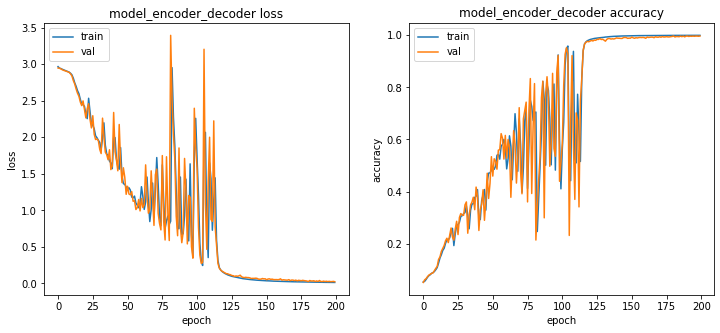

In [6]:
#training
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=40)

## Bahnadau and Luong General Attention Implementations

The implementations are very straightforward given the formulas for the score function and the structure we need to follow.

Initialize weights and other terms involved in the score function. Then in call: expand dimensions to time, compute score, weights and context vector.

In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        ##################
        # YOUR CODE HERE #
        ##################

        # We need to initialized all that is involved in the Bahdanau's attention score formula
        # 2 weight matrices
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        # Single hidden layer network model
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        ##################
        # YOUR CODE HERE #
        ##################
        # Needed and copied from Luong's template
        query_with_time_axis = tf.expand_dims(query, 1)

        # Compute score according to Bahnadau's score formula
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # Normalize the score to compute the attention weights (softmax(score) = exp(score) / sum of all exp(score)s)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Now we may compute the context vector
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [17]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        
        ##################
        # YOUR CODE HERE #
        ##################
        # We need to initialized all that is involved in the Luong's attention score formula
        # Only a weight matrix is needed
        self.W = tf.keras.layers.Dense(units)
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        ##################
        # YOUR CODE HERE #
        ##################

        # Compute score according to Bahnadau's score formula
        # score = tf.matmul(query_with_time_axis, self.W(values_transposed))
        score = tf.transpose(tf.matmul(query_with_time_axis, self.W(values_transposed)), perm=[0, 2, 1])
        # score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed), perm=[0, 2, 1])
   
        # Repeat the same routine as in Bahnadau's Attention implementation
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

## Training

Train models in the exact same way as in the given example.

In [7]:
# Train LuongDotAttention and retrieve model, encoder and decoders (to compare with our implementations)
attention_ld = LuongDotAttention()
model_attention, encoder_lstm_ld, decoder_lstm_ld, decoder_dense_ld = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 148s 3s/step - loss: 2.9671 - accuracy: 0.0538 - val_loss: 2.9472 - val_accuracy: 0.0519
Epoch 2/200
18/18 [==============================] - 12s 674ms/step - loss: 2.9459 - accuracy: 0.0565 - val_loss: 2.9439 - val_accuracy: 0.0641
Epoch 3/200
18/18 [==============================] - 12s 660ms/step - loss: 2.9434 - accuracy: 0.0609 - val_loss: 2.9412 - val_accuracy: 0.0644
Epoch 4/200
18/18 [==============================] - 12s 674ms/step - loss: 2.9400 - accuracy: 0.0701 - val_loss: 2.9348 - val_accuracy: 0.0721
Epoch 5/200
18/18 [==============================] - 12s 662ms/step - loss: 2.9301 - accuracy: 0.0743 - val_loss: 2.9235 - val_accuracy: 0.0765
Epoch 6/200
18/18 [==============================] - 12s 681ms/step - loss: 2.9185 - accuracy: 0.0810 - val_loss: 2.9145 - val_accuracy: 0.0819
Epoch 7/200
18/18 [==============================] - 12s 675ms/step - loss: 2.9099 - accuracy: 0.0851 - val_loss: 2.9045 - val_accuracy: 0

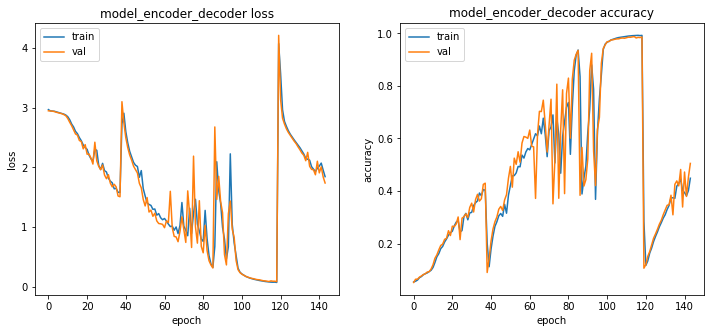

In [9]:
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=25)

In [21]:
# Train BahdanauAttention and retrieve model, encoder and decoders
attention_b = BahdanauAttention(rnn_units)
model_attention, encoder_lstm_b, decoder_lstm_b, decoder_dense_b = build_attention_model(attention_b, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 220s 4s/step - loss: 2.9655 - accuracy: 0.0545 - val_loss: 2.9476 - val_accuracy: 0.0487
Epoch 2/200
18/18 [==============================] - 14s 794ms/step - loss: 2.9458 - accuracy: 0.0570 - val_loss: 2.9432 - val_accuracy: 0.0554
Epoch 3/200
18/18 [==============================] - 14s 762ms/step - loss: 2.9410 - accuracy: 0.0621 - val_loss: 2.9401 - val_accuracy: 0.0604
Epoch 4/200
18/18 [==============================] - 14s 773ms/step - loss: 2.9330 - accuracy: 0.0693 - val_loss: 2.9301 - val_accuracy: 0.0670
Epoch 5/200
18/18 [==============================] - 14s 771ms/step - loss: 2.9241 - accuracy: 0.0773 - val_loss: 2.9192 - val_accuracy: 0.0823
Epoch 6/200
18/18 [==============================] - 14s 764ms/step - loss: 2.9163 - accuracy: 0.0814 - val_loss: 2.9123 - val_accuracy: 0.0842
Epoch 7/200
18/18 [==============================] - 14s 764ms/step - loss: 2.9093 - accuracy: 0.0853 - val_loss: 2.9054 - val_accuracy: 0

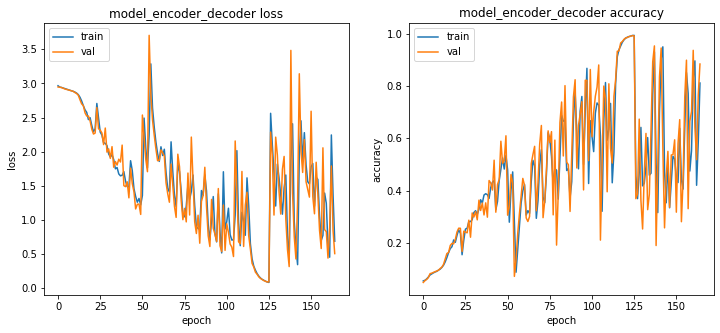

In [22]:
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=40)

In [23]:
# Train LuongGeneralAttention and retrieve model, encoder and decoders
attention_lg = LuongGeneralAttention(rnn_units)
model_attention, encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg = build_attention_model(attention_lg, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 208s 3s/step - loss: 2.9666 - accuracy: 0.0547 - val_loss: 2.9465 - val_accuracy: 0.0522
Epoch 2/200
18/18 [==============================] - 13s 701ms/step - loss: 2.9444 - accuracy: 0.0571 - val_loss: 2.9416 - val_accuracy: 0.0697
Epoch 3/200
18/18 [==============================] - 12s 690ms/step - loss: 2.9393 - accuracy: 0.0660 - val_loss: 2.9345 - val_accuracy: 0.0733
Epoch 4/200
18/18 [==============================] - 12s 687ms/step - loss: 2.9325 - accuracy: 0.0722 - val_loss: 2.9266 - val_accuracy: 0.0756
Epoch 5/200
18/18 [==============================] - 12s 673ms/step - loss: 2.9197 - accuracy: 0.0804 - val_loss: 2.9096 - val_accuracy: 0.0867
Epoch 6/200
18/18 [==============================] - 12s 674ms/step - loss: 2.8966 - accuracy: 0.0931 - val_loss: 2.8812 - val_accuracy: 0.0985
Epoch 7/200
18/18 [==============================] - 12s 690ms/step - loss: 2.8652 - accuracy: 0.1055 - val_loss: 2.8478 - val_accuracy: 0

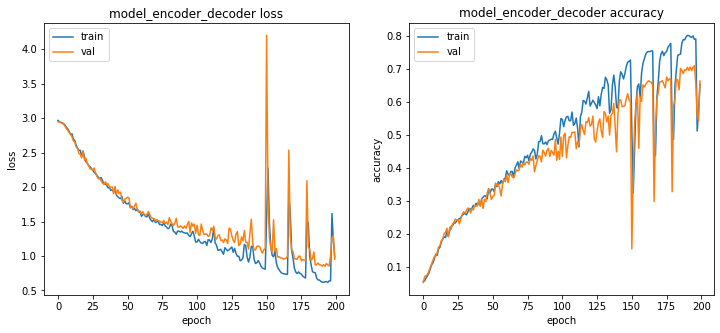

In [24]:
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=25)

## Visualization

Some utils need to be implemented in order to visualize the weights as required. First of all, we need to retreive the different enconders and decoders, which led us to do minor changes in returns of given functions.

The translate method will be the one in charge of triggering the translation through a model evaluation method (which is pretty much based in the build_attention_model method) and also of calling the method that shows the desired plots.

In [25]:
def evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  # Initialize the attention plotting for visualization and enconde input sequence
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(seq_in,n_features)

  # ENCODER STEP (Remember we don't need to initialize it because they are given)
  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]

  all_outputs = []

  # DECODER STEP
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  inputs = decoder_input_data
  decoder_outputs = encoder_state_h

  # Same loop as in build_attention_model. Decoder will only process one timestep at a time.
  for t in range(n_timesteps_in):
      # Pay attention
      # Create the context vector by applying attention to the outputs.
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      # Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      # Storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()
      
      # Passing the concatenated vector to the LSTM
      # Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      # Use the last hidden state for prediction the output, save the current prediction
      # Predictions will be concatenated later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      # Reinject the outputs as inputs for the next loop iteration as well as update the states
      inputs = outputs
      states = [encoder_state_h, encoder_state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])
  
  return seq_in, seq_out, attention_plot

In [29]:
import matplotlib.ticker as ticker

def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(16,16))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  # add labels
  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()



In [30]:
def translate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

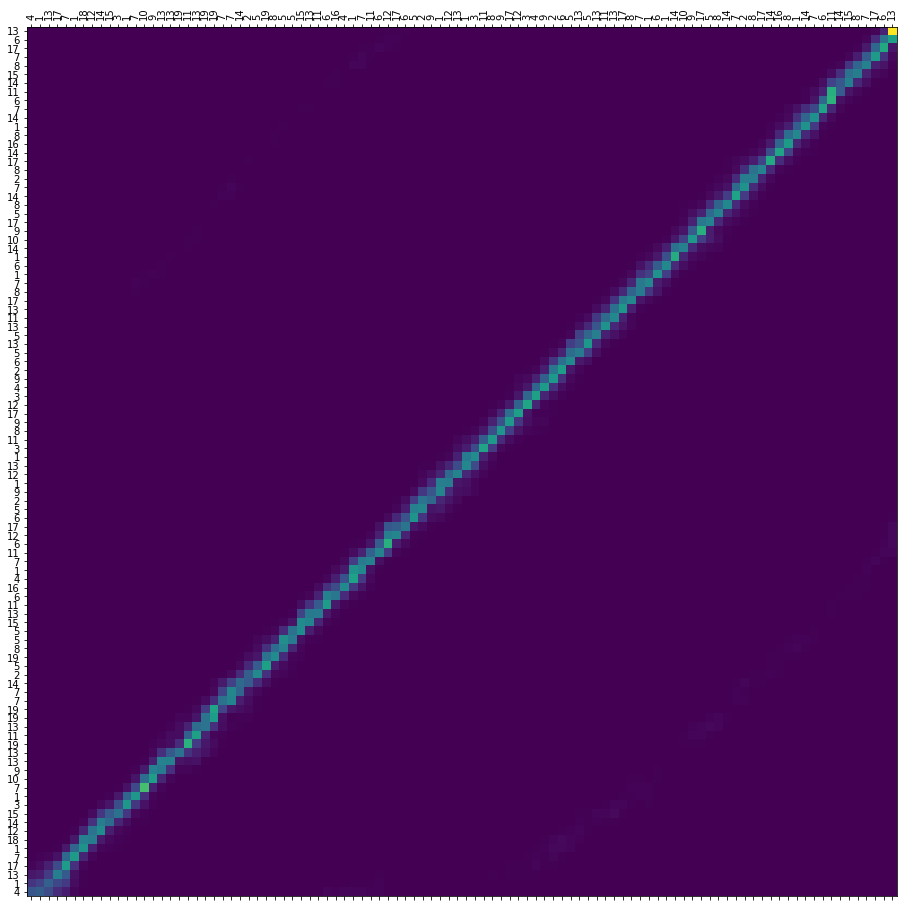

In [31]:
# Plot for each one of the models (LuongDot, LuongGeneralBahdanau)
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_ld, decoder_lstm_ld, decoder_dense_ld, attention_ld)

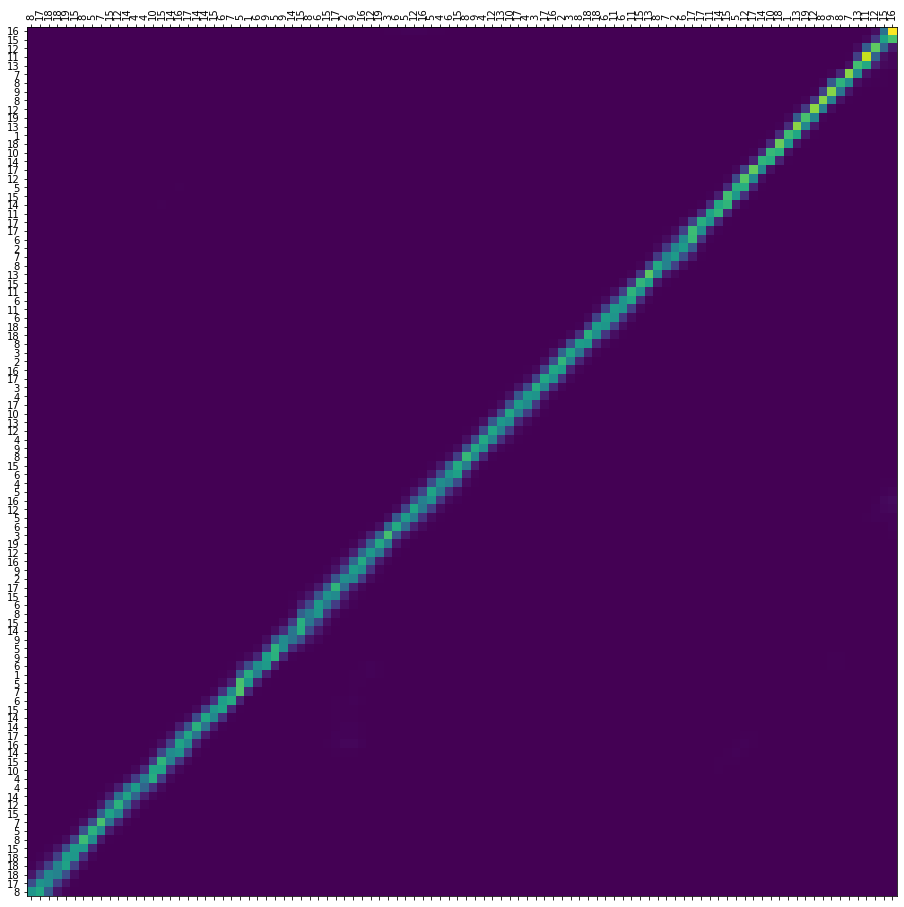

In [32]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_b, decoder_lstm_b, decoder_dense_b, attention_b)


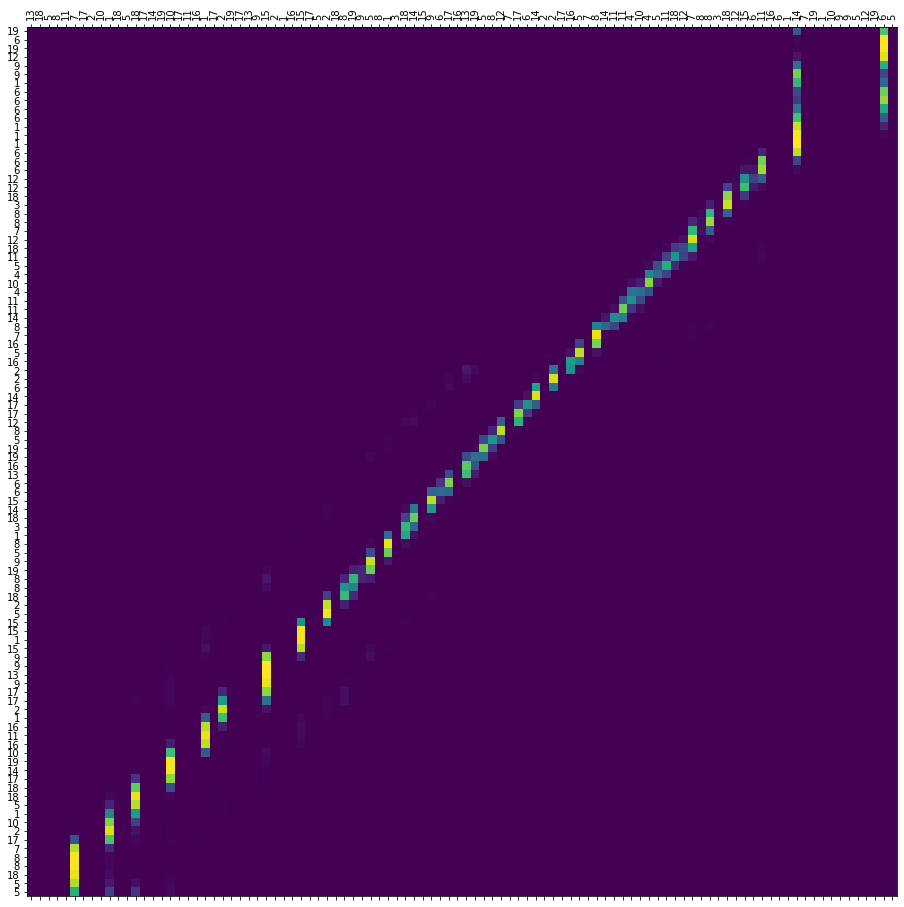

In [33]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg, attention_lg)

Take into account that the diagonal is 'inverted' because of how the axes are ordered. The structure obtained seems to be the one that is desirable. In the last experiment, not enough epochs were executed, but we can claim it is converging towards the same weight visualization matrix structure.

## Comparative

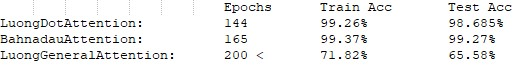

Sadly, this comparison will be a little bit unfair to LuongGeneralAttention as it would have needed way more epochs and time in order to converge and finally obtain similar accuracies to the other two methods.

LuongDotAttention was retrained on the same settings as the two newly implemented attentions.

What can be said about LuongDotAttention and BahnadauAttention is that the latter takes longer to converge, but it leads to better generalization (better test accuracy) than LuongDotAttention, having both of them similar train accuracies.

Last thing to add, as specified in past section, all three attention implementations lead to correct weight visualization matrix structures.

## Blog site

https://hackmd.io/@lorenzovigo/dl-attention